# Monkeypox Prediction Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
#from sklearn import confusion_matrix


In [4]:
IMAGE_SIZE = 224
Batch_size = 10
CHANNELS = 3
EPOCHS =50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="Original Images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=Batch_size,
)

Found 228 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['Monkey Pox', 'Others']

In [7]:
len(dataset) # 8 batches 

23

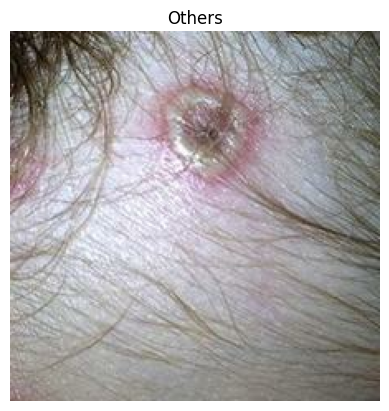

In [112]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [11]:
# dataset partitioning function

def get_datset_partions_tf(ds,train_ratio=0.8,valid_ratio=0.1,Shuffle = True, Shuffle_size =1000 ):


    if Shuffle:
        ds = ds.shuffle(Shuffle_size,seed =123)
    
    ds_size = len(ds)
    train_size = int(train_ratio*ds_size)
    valid_size = int(valid_ratio*ds_size)
    test_size = int(train_ratio*ds_size)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds,valid_ds,test_ds



In [12]:
train_ds,valid_ds,test_ds = get_datset_partions_tf(dataset)

In [13]:
#dataset optimization for high training performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)  #set for Prefetch the images
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [115]:
#Layer for rescale and resize images (Helpful when testing with different size image)
resize_and_rescale = tf.keras.Sequential([
                        keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                        keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
#Layer for Data augmentation 
Augmentation = tf.keras.Sequential([
                        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                        keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

## CNN

In [116]:

input_shape = (Batch_size,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 2

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape =input_shape ),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" ),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128,activation = "relu"),
    keras.layers.Dense(1,activation = "sigmoid")



])
#use only if resize layers are used
model.build(input_shape=input_shape)

In [117]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (10, 224, 224, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (10, 224, 224, 3)         0         
                                                                 
 conv2d_44 (Conv2D)          (10, 222, 222, 32)        896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (10, 111, 111, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (10, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (10, 54, 54, 64)         0         
 g2D)                                                

In [129]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'] #the parameter which track at each epoch
            )

In [130]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=Batch_size,
    verbose=1,
    validation_data=valid_ds
)

Epoch 1/50
18/18 [==============================] - 8s 378ms/step - loss: 0.6760 - accuracy: 0.6067 - val_loss: 0.6935 - val_accuracy: 0.5500
Epoch 2/50
18/18 [==============================] - 6s 338ms/step - loss: 0.6808 - accuracy: 0.5843 - val_loss: 0.6681 - val_accuracy: 0.5500
Epoch 3/50
18/18 [==============================] - 7s 391ms/step - loss: 0.6671 - accuracy: 0.5787 - val_loss: 0.6613 - val_accuracy: 0.5500
Epoch 4/50
18/18 [==============================] - 7s 401ms/step - loss: 0.6694 - accuracy: 0.6292 - val_loss: 0.6980 - val_accuracy: 0.5500
Epoch 5/50
18/18 [==============================] - 7s 416ms/step - loss: 0.6781 - accuracy: 0.5899 - val_loss: 0.6545 - val_accuracy: 0.6000
Epoch 6/50
18/18 [==============================] - 8s 431ms/step - loss: 0.6685 - accuracy: 0.5843 - val_loss: 0.6564 - val_accuracy: 0.5500
Epoch 7/50
18/18 [==============================] - 7s 409ms/step - loss: 0.6557 - accuracy: 0.6180 - val_loss: 0.6401 - val_accuracy: 0.6000
Epoch 

In [131]:
#training progress keeping variables

loss = history.history['loss']
accuracy= history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']


Text(0.5, 1.0, 'Accuracy')

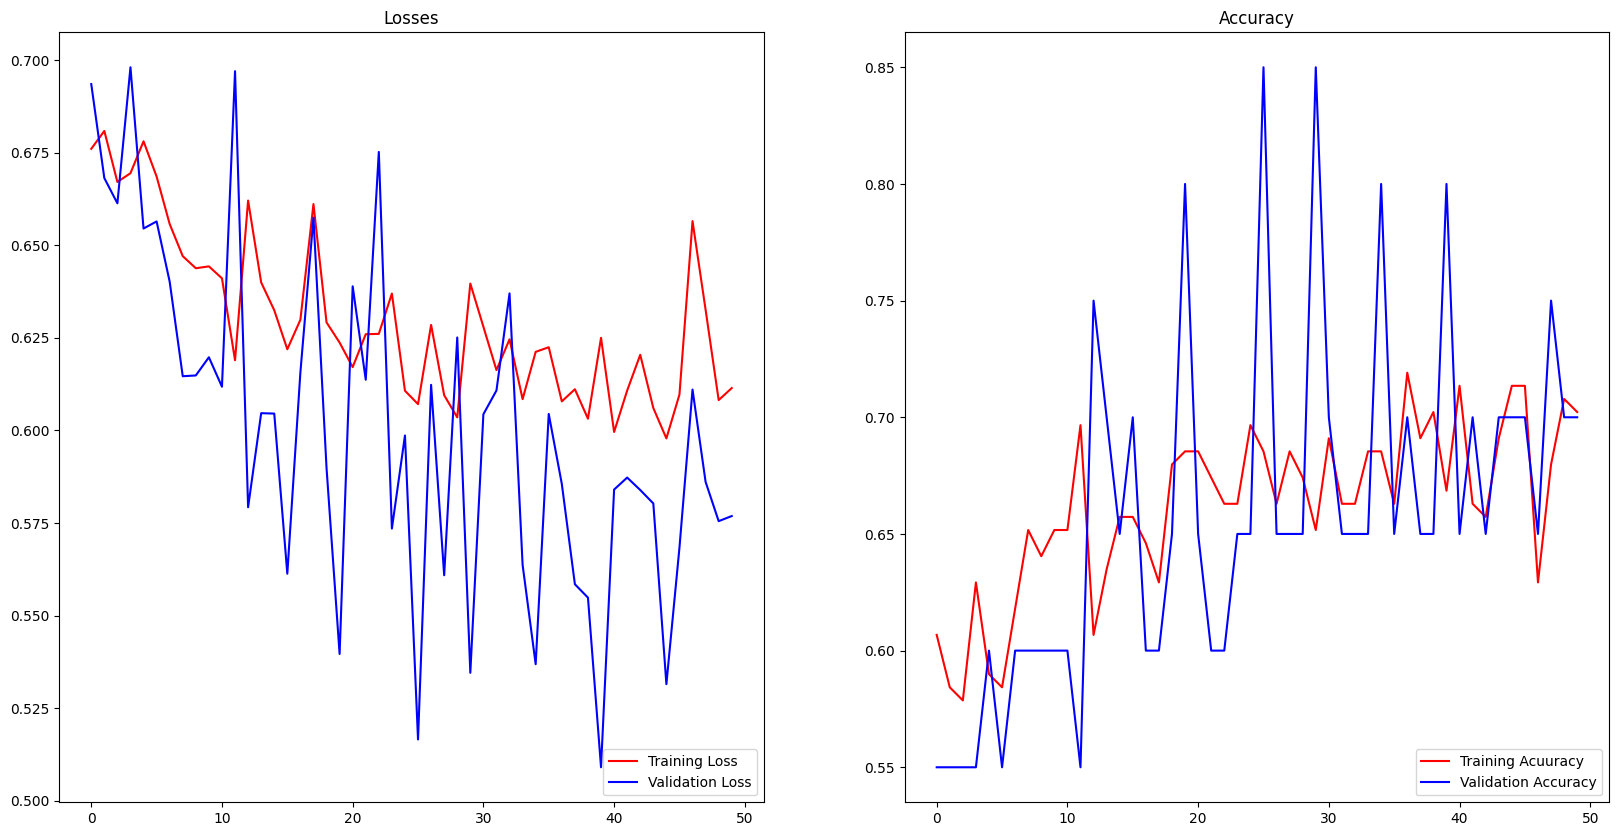

In [132]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,'r',label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,'b',label = 'Validation Loss')
plt.legend(loc='lower right')
plt.title("Losses")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),accuracy,'r',label = 'Training Acuuracy')
plt.plot(range(EPOCHS),val_accuracy,'b',label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Accuracy")

First image to predict
First image actual label : Others
1/1 [==============================] - 0s 96ms/step
Predicted result :Monkey Pox


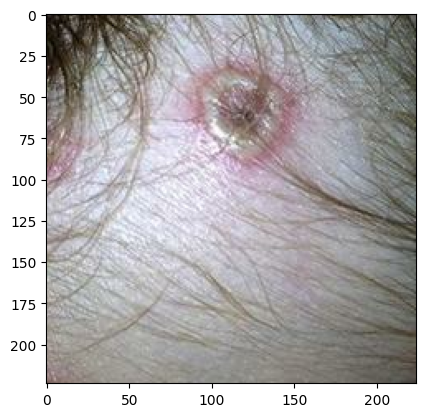

In [128]:
for image_batch,label_batch in dataset.take(1):
    first_image  = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print(f"First image actual label : {class_names[first_label]}")

    batch_prediction = model.predict(image_batch)

    print(f"Predicted result :{class_names[np.argmax(batch_prediction[0])]}")
    

In [128]:
model_version = 1
model.save(f"Monkeypox_prediction_{model_version}.h5")